# Introduction and Overview
For assignment 2, I selected the fourth Jester dataset in [http://eigentaste.berkeley.edu/dataset/] This dataset consists of two parts - a user rating dataset where 7000+ users rated distinct 158 jokes, and a jokes dataset consisting of a single column of jokes that were rated.  

The general strategy of my recommender system will be as follows:

1.  Develop a baseline for comparison.  This will be done using the same method in Project 1, where the mean of all user ratings among all jokes is used to establish a baseline.  The user ratings dataset will be split into a testing set and a training set, with a 80% - 20% split.
2.  Incorporate Content-Based filtering by using tf-idf to determine similarity between jokes.  A prediction can be developed using a user's own joke ratings and the cosine-similarity matrix calculated with the tf-idf.
3.  Incorporate User-Item collaborative filtering using NearestNeighbors to find similar users and predicting ratings based on weighted average of nearest neighbors.  Weights will be determined by cosine similarity, where more similar neighbors have higher weights.
4.  Combined Content-Based filtering and User-Item collaborative filtering by using content-based rating predictions for the K-nearest neighbors if actual ratings do not exist.  Additionally, if more than a certain threshold of nearest neighbors do not have an actual rating, use the content-based prediction instead.

Each of these recommender systems will be assessed against the baseline, using root mean squared error - the square root of the average squared errors - as the metric to compare performances.   

# Data Pre-Processing
First, I import relevant packages and the joke ratings dataset (final.csv).  I pre-process the data so that the first column - containing the sum of jokes rated per user - is dropped, and the format of the data is structured from wide to long (i.e. each entry is a user - joke combination with the rating listed).  

In [327]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors as KNN

# import the user ratings
user_ratings = pd.read_csv("https://raw.githubusercontent.com/koonkimb/Data612/refs/heads/main/Project_2/data/final.csv", header = None) 
user_ratings_df = user_ratings.drop(user_ratings.columns[0],axis = 1) # drop the first column which is number of jokes rated
user_ratings_df = user_ratings_df.transpose() # transposing the matrix switches columns and rows
user_ratings_df = user_ratings_df.reset_index() # reset index so that columns start at 0 again
user_ratings_df = user_ratings_df.drop('index',axis = 1) # drop the index column
user_ratings_df = user_ratings_df.transpose() # revert back to original structure
user_ratings_df = user_ratings_df.reset_index() # reset index so that we can melt df with index as the id_vars
print(user_ratings_df)

user_ratings_long = user_ratings_df.melt(id_vars='index', var_name='joke', value_name='rating') # change df structure from wide to long
print(user_ratings_long)

      index     0     1     2     3     4     5     6     7     8  ...    148  \
0         0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
1         1  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
2         2  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
3         3  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
4         4  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
...     ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...    ...   
7694   7694  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...   0.00   
7695   7695  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
7696   7696  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   
7697   7697  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...   2.03   
7698   7698  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  99.0  ...  99.00   

        149    150    151  

I dropped the user - joke ratings that were designated as "99" as "99" rating indicates unrated.  Then I split the dataset into a training and test set.

In [328]:
user_ratings_dropped = user_ratings_long
user_ratings_dropped['rating'] = user_ratings_dropped['rating'].replace(99,np.nan) # replace 99 with np.nan as entries with 99 rating were not rated
user_ratings_dropped = user_ratings_dropped.dropna() # drop the NA records
df_random = user_ratings_dropped.sample(frac = 1, random_state = 63) # randomize the records
split_size = int(0.8*len(df_random)) # designate split size (80%)
train = df_random[:split_size] # split dataset into 80% train and 20% test
test = df_random[split_size:]

print(train)
print(test)

         index joke  rating
270614    1149   35    2.93
597375    4552   77   -2.72
264573    2807   34    0.00
146048    7466   18    7.00
494479    1743   64    0.00
...        ...  ...     ...
142383    3801   18   -3.05
1110350   1694  144    3.05
142552    3970   18   -3.74
266408    4642   34    0.00
1174114   3866  152   -5.26

[85191 rows x 3 columns]
        index joke  rating
424789   1344   55    5.12
548349   1720   71    6.95
548375   1746   71   -8.03
600614     92   78    0.00
377185   7633   48   20.00
...       ...  ...     ...
133417   2534   17  -10.00
366276   4423   47    0.00
434127   2983   56    0.00
165136   3457   21    9.63
837185   5693  108    2.31

[21298 rows x 3 columns]


I pivot back the database from long to wide format.  This dataset now has NaN instead of 99 for unrated user - joke combinations.

In [329]:
pivot_train = train.pivot(index='index', columns='joke', values='rating') # pivot the training data back into original format with jokes as columns
print(pivot_train)
pivot_test = test.pivot(index='index', columns='joke', values='rating') # pivot the testing data back into original format with jokes as columns
print(pivot_test)

joke   6    7    12   14   15   16   17    18    20   21   ...   148   149  \
index                                                      ...               
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   NaN   NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   NaN   NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN -4.59  NaN  ...   NaN   NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN -7.72   NaN  NaN  ...   NaN   NaN   
5      NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.39   NaN  NaN  ...   NaN  3.19   
...    ...  ...  ...  ...  ...  ...  ...   ...   ...  ...  ...   ...   ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  0.00  0.00  NaN  ...   NaN   NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN -9.51   NaN  NaN  ...   NaN   NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN   NaN   NaN  NaN  ...   NaN  8.63   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  2.52  5.37  NaN  ...  2.03   NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  4.59   NaN  NaN  ...  

Next, I fill in the training and test matrices with missing users and jokes in each set.  That is, if there are any missing rows (users) or columns (jokes), I insert a full row or column of NaN.  

In [330]:
reindex = list(range(7699)) # create an index from 0 to 7698, representing an index of users
column_reindex = list(range(158)) # create an index from 0 to 157, representing an index of jokes
pivot_train_reindex = pivot_train.reindex(reindex).fillna(np.nan) # reindex the df with all users and fill in nan
pivot_train_reindex_transpose = pivot_train_reindex.transpose() # swap rows and columns
pivot_train_reindex_transpose = pivot_train_reindex_transpose.reindex(column_reindex).fillna(np.nan) # reindex df with all columns and fill in nan
pivot_train_reindex = pivot_train_reindex_transpose.transpose() # swap back rows and columns

pivot_test_reindex = pivot_test.reindex(reindex).fillna(np.nan) # reindex the df with all users and fill in nan
pivot_test_reindex_transpose = pivot_test_reindex.transpose() # swap rows and columns
pivot_test_reindex_transpose = pivot_test_reindex_transpose.reindex(column_reindex).fillna(np.nan) # reindex df with all columns and fill in nan
pivot_test_reindex = pivot_test_reindex_transpose.transpose() # swap back rows and columns

print(pivot_train_reindex)
print(pivot_test_reindex)

joke   0    1    2    3    4    5    6    7    8    9    ...   148   149  \
index                                                    ...               
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN  8.63   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  2.03   NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   

joke    150

# Step 1: Establish a Global Baseline
I calculate the global baseline using the mean value of all known ratings in the training set.  

In [331]:
train_means = np.nanmean(pivot_train_reindex.values) # get mean of all values in the df
print(train_means)

0.5318867016468877


A matrix of the above mean is created, and then all values except for the ones associated to known ratings are masked with NaN.  This is done for the training and testing set.

In [332]:
is_na = pivot_train_reindex.isna().astype(int) # create an is_na matrix

# create matrix of ones, then multiply by the mean, then multiply by the is_na matrix so that NaN values are replaced by 0
train_means_df = np.ones((7699,158)) * train_means * (1-is_na)

is_na_test = pivot_test_reindex.isna().astype(int) # create an is_na matrix

# create matrix of ones, then multiply by the mean, then multiply by the is_na matrix so that NaN values are replaced by 0
test_means_df = np.ones((7699,158)) * train_means * (1-is_na_test)

#convert to dataframe, then replace 0 with NaN
train_means_df = pd.DataFrame(train_means_df)
train_means_df = train_means_df.replace(0, np.nan)

User bias is calculated by taking the mean rating of each user and subtracting the average rating across all ratings.

In [334]:
user_bias = pivot_train_reindex.mean(axis=1) - train_means # find user bias by taking mean rating for each user
print(user_bias)

index
0        3.168113
1             NaN
2        0.051447
3        0.595411
4       -0.860887
          ...    
7694    -0.101432
7695   -10.041887
7696     2.223113
7697     1.395172
7698     3.693113
Length: 7699, dtype: float64


Joke bias is calculated by taking the mean rating of each joke and subtracting the average rating across all ratings.

In [335]:
joke_bias = pivot_train_reindex.mean() - train_means # find joke bias by taking mean rating for each joke
print(joke_bias)

joke
0           NaN
1           NaN
2           NaN
3           NaN
4           NaN
         ...   
153   -1.211308
154   -2.060754
155   -1.884826
156   -0.555840
157   -0.545272
Length: 158, dtype: float64


User and joke biases are taken into account by adding them to the matrix of average ratings. This is done for both the training and test set.   

In [336]:
train_means_user_bias = train_means_df.add(user_bias, axis = 0)
train_means_bias = train_means_df.add(joke_bias, axis = 1)
train_means_bias[train_means_bias > 10] = 10 # cap maximum ratings at 10
train_means_bias[train_means_bias < -10] = -10 # cap minimal ratings at -10
print(train_means_bias)

joke   0    1    2    3    4    5    6    7    8    9    ...       148  \
index                                                    ...             
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.843352   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   

joke        149       150      151   

In [337]:
test_means_user_bias = test_means_df.add(user_bias, axis = 0)
test_means_bias = test_means_df.add(joke_bias, axis = 1)
test_means_bias[test_means_bias > 10] = 10
test_means_bias[test_means_bias < -10] = -10
print(test_means_bias)

joke   0    1    2    3    4    5         6         7    8    9    ...  \
index                                                              ...   
0      NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
1      NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
2      NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
3      NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
4      NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
...    ...  ...  ...  ...  ...  ...       ...       ...  ...  ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
7695   NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
7696   NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
7697   NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   
7698   NaN  NaN  NaN  NaN  NaN  NaN -2.404184 -2.141964  NaN  NaN  ...   

joke        148       149       150  

Using the user biases and joke biases, I can then determine the final baseline RMSE for the training and test set.

In [338]:
rmse_bias_train = (((pivot_train_reindex - train_means_bias) ** 2).to_numpy())
rmse_bias_train = np.sqrt(np.nanmean(rmse_bias_train))
print(rmse_bias_train)

4.924629966850917


In [339]:
rmse_bias_test = (((pivot_test_reindex - test_means_bias) ** 2).to_numpy())
rmse_bias_test = np.sqrt(np.nanmean(rmse_bias_test))
print(rmse_bias_test)

4.9759449701058625


# Step 2: Content-Based Filtering
Per step 2 of the plan outlined above, I can incorporate content based filtering with tf-idf.  I used scikit-learn's TfidfVectorizer to do this.  I start by importing the joke set data, which is 158 jokes (158 records in a single column dataset).

In [340]:
# Import the data
jokes_df = pd.read_csv("https://raw.githubusercontent.com/koonkimb/Data612/refs/heads/main/Project_2/data/Dataset4JokeSet.csv", header = None)
print(jokes_df)

                                                     0
0    A man visits the doctor. The doctor says "I ha...
1    This couple had an excellent relationship goin...
2    Q. What's 200 feet long and has 4 teeth?   A. ...
3    Q. What's the difference between a man and a t...
4    Q.\tWhat's O. J. Simpson's Internet address?  ...
..                                                 ...
153  Poodle: "My life is a mess. My owner is mean, ...
154  Did you hear that NASA has launched several co...
155  A bear walks into a bar and says,"I'd like a b...
156  A dog goes into a bar and orders a martini. Th...
157  I'm reading a great book about antigravity -- ...

[158 rows x 1 columns]


I remove all integers from the joke data, as TfidVectorizer converts all strings to lowercase, which will error out if passed an integer. 

In [341]:
# use regex to remove any integers, as the TfidfVectorizer will convert all strings to lowercase with a function that cannot take in integers
jokes_df_string = jokes_df
jokes_df_string[0] = jokes_df_string[0].replace(r'\d+', '', regex = True)
print(jokes_df_string)

                                                     0
0    A man visits the doctor. The doctor says "I ha...
1    This couple had an excellent relationship goin...
2    Q. What's  feet long and has  teeth?   A. The ...
3    Q. What's the difference between a man and a t...
4    Q.\tWhat's O. J. Simpson's Internet address?  ...
..                                                 ...
153  Poodle: "My life is a mess. My owner is mean, ...
154  Did you hear that NASA has launched several co...
155  A bear walks into a bar and says,"I'd like a b...
156  A dog goes into a bar and orders a martini. Th...
157  I'm reading a great book about antigravity -- ...

[158 rows x 1 columns]


I then initialize vectorizer and pass in the joke string data from above.  I use English stop words, which eliminates the use of common words like "the".  I use get_feature_names_out() show the extracted features (i.e. words) from the 158 jokes.  I can also access a full maping of the words to index using vocabulary_.  The variable X shows the joke, word, and tf-idf score of the word.  

In [342]:
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(jokes_df_string[0])
print(vectorizer.get_feature_names_out()) # extracted features (words) from the 158 jokes
print(vectorizer.vocabulary_) # full mapping of words to index
print(X.shape) # shape of tfidf matrix
print(X) # for each joke (indexed by the first number in coordinate), shows the word (indexed by the second number in the coordinate;
# can cross reference with vocabulary_ from above) and the tf-idf score of the word

['able' 'abortion' 'accident' ... 'younger' 'zipper' 'zo']
{'man': 1084, 'visits': 1901, 'doctor': 512, 'says': 1538, 'bad': 133, 'news': 1197, 'cancer': 264, 'alzheimer': 41, 'disease': 501, 'replies': 1464, 'thank': 1796, 'god': 758, 'don': 520, 'couple': 400, 'excellent': 603, 'relationship': 1450, 'going': 761, 'day': 440, 'came': 259, 'home': 858, 'work': 1976, 'girlfriend': 749, 'packing': 1258, 'asked': 93, 'leaving': 1001, 'told': 1823, 'heard': 826, 'awful': 124, 'things': 1801, 'possibly': 1352, 'said': 1521, 'make': 1078, 'pedophile': 1294, 'replied': 1463, 'awfully': 125, 'big': 167, 'word': 1974, 'year': 1996, 'old': 1230, 'feet': 649, 'long': 1048, 'teeth': 1781, 'row': 1508, 'willie': 1954, 'nelson': 1191, 'concert': 368, 'difference': 486, 'toilet': 1820, 'doesn': 515, 'follow': 691, 'use': 1875, 'simpson': 1615, 'internet': 911, 'address': 11, 'slash': 1632, 'backslash': 131, 'escape': 587, 'hillary': 845, 'trip': 1848, 'arkansas': 80, 'gas': 731, 'pulls': 1391, 'servi

Cosine similarity is calculated for each joke, in comparison to all jokes, using cosine_similarity from scikit-learn.  

In [343]:
cosine_sim = cosine_similarity(X,X)
print(cosine_sim.shape)
print(cosine_sim)
cosine_sim_jokes = pd.DataFrame(cosine_sim)

(158, 158)
[[1.         0.         0.         ... 0.03849341 0.04877435 0.        ]
 [0.         1.         0.         ... 0.04504245 0.         0.        ]
 [0.         0.         1.         ... 0.         0.         0.        ]
 ...
 [0.03849341 0.04504245 0.         ... 1.         0.16401938 0.        ]
 [0.04877435 0.         0.         ... 0.16401938 1.         0.        ]
 [0.         0.         0.         ... 0.         0.         1.        ]]


I can plot the cosine similarity as a correlation plot, to visually see similarity between jokes.  From the below, we can see that a small percentage of jokes are very similar, while jokes do not show a high degree of similarity.  

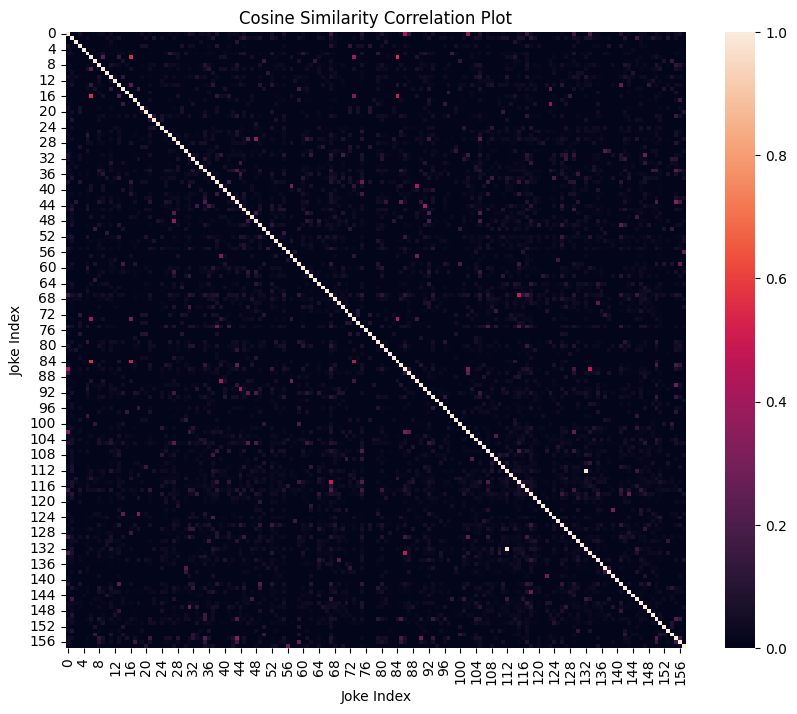

In [394]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 8))
sns.heatmap(cosine_sim_jokes)
plt.title('Cosine Similarity Correlation Plot')
plt.xlabel('Joke Index')
plt.ylabel('Joke Index')
plt.show()

I replace the NaN values in the dataframe containing the training set to allow a dot product operation between the training set and cosine similarity matrix.  This is done for the test set as well.  

In [344]:
train_zero = pivot_train_reindex.replace(np.nan,0)
recommendation_train = train_zero.dot(cosine_sim_jokes)
print(recommendation_train)

            0         1         2         3    4         5         6    \
index                                                                    
0      0.000000  0.038697  0.000000  0.000000  0.0  0.000000  0.000000   
1      0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
2     -0.112501  0.316217 -0.171377  0.201677  0.0  0.004553  0.000000   
3      1.064374  0.886653  0.000000 -0.449893  0.0  1.325902  0.832003   
4      0.000000  0.046331  0.000000  0.000000  0.0  0.000000  0.000000   
...         ...       ...       ...       ...  ...       ...       ...   
7694   0.323531  0.000000  0.363074  0.000000  0.0  0.034140  0.000000   
7695   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
7696   2.726277  2.615214  0.018710  1.541704  0.0  0.983397  0.616287   
7697   1.804813  2.475106  0.022978  1.176841  0.0  1.486106  0.746487   
7698   0.000000  0.040370  0.000000  0.000000  0.0  0.000000  0.000000   

            7         8         9    

In [345]:
test_zero = pivot_test_reindex.replace(np.nan,0)
recommendation_test = test_zero.dot(cosine_sim_jokes)
print(recommendation_test)

            0         1         2         3    4         5         6    \
index                                                                    
0      0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
1      0.000000  0.085865  0.000000  0.000000  0.0  0.000000  0.000000   
2      0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
3      0.833909 -0.023999  0.056406  0.317960  0.0  0.121353 -0.103138   
4      0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
...         ...       ...       ...       ...  ...       ...       ...   
7694   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
7695   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   
7696   0.490537  0.567192  0.000000  0.517598  0.0  0.100755  0.000000   
7697   0.989153  0.374167  0.101836  0.639184  0.0  0.399469  0.111932   
7698   0.000000  0.000000  0.000000  0.000000  0.0  0.000000  0.000000   

            7         8         9    

I then add in the global baseline to compute the full predicted ratings from the outputs above.  I cap maximum and minimum ratings to 10 and -10 respectively, per the boundaries of the original dataset.  

In [346]:
full_train_recommendation = train_means_bias + recommendation_train
full_train_recommendation[full_train_recommendation > 10] = 10
full_train_recommendation[full_train_recommendation < -10] = -10

In [347]:
full_test_recommendation = test_means_bias + recommendation_test
full_test_recommendation[full_test_recommendation > 10] = 10
full_test_recommendation[full_test_recommendation < -10] = -10

I then can use this matrix of predicted ratings to compute the RMSE and compare it to the global baseline RMSE.  For the training set, I can see an improvement of about 58%.  For the test set, there is an improvement of about 70%.  

In [348]:
rmse_bias_train = (((pivot_train_reindex - full_train_recommendation) ** 2).to_numpy())
rmse_bias_train = np.sqrt(np.nanmean(rmse_bias_train))
print(pivot_train_reindex)
print(full_train_recommendation)
print(rmse_bias_train)

joke   0    1    2    3    4    5    6    7    8    9    ...   148   149  \
index                                                    ...               
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN  8.63   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  2.03   NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...   NaN   NaN   

joke    150

In [349]:
rmse_bias_test = (((pivot_test_reindex - full_test_recommendation) ** 2).to_numpy())
rmse_bias_test = np.sqrt(np.nanmean(rmse_bias_test))
print(pivot_test_reindex)
print(full_test_recommendation)
print(rmse_bias_test)

joke   0    1    2    3    4    5    6    7    8    9    ...  148  149   150  \
index                                                    ...                   
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  NaN   NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN   NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  2.05   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN

# Step 3: Collaborative Filtering
Per step 3 from above, I will also incorporate user-item collaborating filtering in this recommender.  This will be done by clustering users using cosine similarity and finding the n nearest neighbors.  I use NearesetNeighbors from Scikit-Learn, and fill the training dataset with 0 to replace NaN.  

In [367]:
pivot_train_reindex_0 = pivot_train_reindex.fillna(0)
knn = KNN(metric = 'cosine', algorithm = 'brute')
knn.fit(pivot_train_reindex_0)

NearestNeighbors(algorithm='brute', metric='cosine')

I then create a dictionary to store the nearest neighbors and cosine distances.  I remove the first entry, which is the cosine distance and index of the original user (i.e. so that the nearest neighbor does not include itself).  Given the sparseness of the dataset in terms of rated jokes, I use a low number of n_neighbors.  

In [368]:
nearest_neighbors_dict = {}
for user_index in reindex:
    distances, indices = knn.kneighbors(pivot_train_reindex_0.iloc[user_index,:].values.reshape(1,-1), n_neighbors = 3)
    nearest_neighbors_dict[user_index] = [distances[:, 1:], indices[:, 1:]] # remove self as nearest neighbor

I use the is_na matrix to create a dataframe that determines whether a user-joke combination requires prediction.  

In [369]:
needs_prediction_df = 1 - is_na
needs_prediction_df = needs_prediction_df.reindex()
needs_prediction_df = needs_prediction_df.reset_index().rename(columns={'index': 'user'})
needs_prediction_df = needs_prediction_df.melt(id_vars='user', var_name='joke', value_name='needs_prediction') 
print(needs_prediction_df)
needs_prediction_df = needs_prediction_df[needs_prediction_df['needs_prediction'] == 1]
print(needs_prediction_df)

         user joke  needs_prediction
0           0    0                 0
1           1    0                 0
2           2    0                 0
3           3    0                 0
4           4    0                 0
...       ...  ...               ...
1216437  7694  157                 0
1216438  7695  157                 0
1216439  7696  157                 1
1216440  7697  157                 1
1216441  7698  157                 0

[1216442 rows x 3 columns]
         user joke  needs_prediction
46233      39    6                 1
46282      88    6                 1
46286      92    6                 1
46304     110    6                 1
46319     125    6                 1
...       ...  ...               ...
1216400  7657  157                 1
1216425  7682  157                 1
1216433  7690  157                 1
1216439  7696  157                 1
1216440  7697  157                 1

[85191 rows x 3 columns]


I initialize a prediction matrix, to insert predictions later.  

In [370]:
pred = is_na
pred = pred.replace(1, np.nan)
pred

joke   0    1    2    3    4    5    6    7    8    9    ...  148  149  150  \
index                                                    ...                  
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  0.0  NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  NaN  NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

joke   151  152  153  154  155  156  157  
index                                     
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3      NaN  0.0  0.0  NaN  0.0  NaN  NaN  
4      NaN  NaN  0.0  NaN  NaN  NaN  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
7694   NaN  0.0  NaN  0.0  0.0  0.0  NaN  
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7696   0.0  0.0  0.0  NaN  NaN  NaN  0.0  
7697   0.0  0.0  0.0  0.0  0.0  NaN  0.0  
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[7699 rows x 158 columns]

I create a full global baseline matrix using the same strategy as in step 1 from this assignment, but for all user-joke combinations (i.e. not only for the user-joke combinations that have ratings).  

In [371]:
global_baseline = pd.DataFrame(np.ones((7699,158)) * train_means)
user_bias_0 = user_bias.fillna(0)
joke_bias_0 = joke_bias.fillna(0)
global_baseline = global_baseline.add(user_bias_0, axis = 0)
global_baseline = global_baseline.add(joke_bias_0, axis = 1)
global_baseline[global_baseline > 10] = 10
global_baseline[global_baseline < -10] = -10
global_baseline

0         1         2         3         4         5          6    \
0     3.700000  3.700000  3.700000  3.700000  3.700000  3.700000   1.295816   
1     0.531887  0.531887  0.531887  0.531887  0.531887  0.531887  -1.872297   
2     0.583333  0.583333  0.583333  0.583333  0.583333  0.583333  -1.820851   
3     1.127297  1.127297  1.127297  1.127297  1.127297  1.127297  -1.276887   
4    -0.329000 -0.329000 -0.329000 -0.329000 -0.329000 -0.329000  -2.733184   
...        ...       ...       ...       ...       ...       ...        ...   
7694  0.430455  0.430455  0.430455  0.430455  0.430455  0.430455  -1.973729   
7695 -9.510000 -9.510000 -9.510000 -9.510000 -9.510000 -9.510000 -10.000000   
7696  2.755000  2.755000  2.755000  2.755000  2.755000  2.755000   0.350816   
7697  1.927059  1.927059  1.927059  1.927059  1.927059  1.927059  -0.477125   
7698  4.225000  4.225000  4.225000  4.225000  4.225000  4.225000   1.820816   

            7         8         9    ...       148       149        150  \
0      1.558036  3.700000  3.700000  ...  4.011466  4.937709   1.926826   
1     -1.610077  0.531887  0.531887  ...  0.843352  1.769596  -1.241287   
2     -1.558630  0.583333  0.583333  ...  0.894799  1.821042  -1.189841   
3     -1.014667  1.127297  1.127297  ...  1.438763  2.365006  -0.645877   
4     -2.470964 -0.329000 -0.329000  ... -0.017534  0.908709  -2.102174   
...         ...       ...       ...  ...       ...       ...        ...   
7694  -1.711509  0.430455  0.430455  ...  0.741920  1.668163  -1.342719   
7695 -10.000000 -9.510000 -9.510000  ... -9.198534 -8.272291 -10.000000   
7696   0.613036  2.755000  2.755000  ...  3.066466  3.992709   0.981826   
7697  -0.214905  1.927059  1.927059  ...  2.238525  3.164768   0.153885   
7698   2.083036  4.225000  4.225000  ...  4.536466  5.462709   2.451826   

           151        152        153        154        155        156  \
0     3.394263   2.583836   2.488692   1.639246   1.815174   3.144160   
1     0.226150  -0.584278  -0.679421  -1.528868  -1.352940  -0.023953   
2     0.277597  -0.532831  -0.627974  -1.477421  -1.301493   0.027493   
3     0.821561   0.011133  -0.084011  -0.933457  -0.757529   0.571457   
4    -0.634737  -1.445164  -1.540308  -2.389754  -2.213826  -0.884840   
...        ...        ...        ...        ...        ...        ...   
7694  0.124718  -0.685710  -0.780853  -1.630300  -1.454372  -0.125386   
7695 -9.815737 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
7696  2.449263   1.638836   1.543692   0.694246   0.870174   2.199160   
7697  1.621322   0.810894   0.715751  -0.133695   0.042233   1.371219   
7698  3.919263   3.108836   3.013692   2.164246   2.340174   3.669160   

            157  
0      3.154728  
1     -0.013385  
2      0.038061  
3      0.582025  
4     -0.874272  
...         ...  
7694  -0.114817  
7695 -10.000000  
7696   2.209728  
7697   1.381787  
7698   3.679728  

[7699 rows x 158 columns]

I use combine_first() to combine in the actual ratings if they exist (otherwise, the global baseline is used).  

In [372]:
train_with_global_baseline = pivot_train_reindex.combine_first(global_baseline)
train_with_global_baseline

0         1         2         3         4         5          6    \
index                                                                          
0      3.700000  3.700000  3.700000  3.700000  3.700000  3.700000   1.295816   
1      0.531887  0.531887  0.531887  0.531887  0.531887  0.531887  -1.872297   
2      0.583333  0.583333  0.583333  0.583333  0.583333  0.583333  -1.820851   
3      1.127297  1.127297  1.127297  1.127297  1.127297  1.127297  -1.276887   
4     -0.329000 -0.329000 -0.329000 -0.329000 -0.329000 -0.329000  -2.733184   
...         ...       ...       ...       ...       ...       ...        ...   
7694   0.430455  0.430455  0.430455  0.430455  0.430455  0.430455  -1.973729   
7695  -9.510000 -9.510000 -9.510000 -9.510000 -9.510000 -9.510000 -10.000000   
7696   2.755000  2.755000  2.755000  2.755000  2.755000  2.755000   0.350816   
7697   1.927059  1.927059  1.927059  1.927059  1.927059  1.927059  -0.477125   
7698   4.225000  4.225000  4.225000  4.225000  4.225000  4.225000   1.820816   

             7         8         9    ...       148       149        150  \
index                                 ...                                  
0       1.558036  3.700000  3.700000  ...  4.011466  4.937709   1.926826   
1      -1.610077  0.531887  0.531887  ...  0.843352  1.769596  -1.241287   
2      -1.558630  0.583333  0.583333  ...  0.894799  1.821042  -1.189841   
3      -1.014667  1.127297  1.127297  ...  1.438763  2.365006   5.610000   
4      -2.470964 -0.329000 -0.329000  ... -0.017534  0.908709  -2.102174   
...          ...       ...       ...  ...       ...       ...        ...   
7694   -1.711509  0.430455  0.430455  ...  0.741920  1.668163   0.000000   
7695  -10.000000 -9.510000 -9.510000  ... -9.198534 -8.272291 -10.000000   
7696    0.613036  2.755000  2.755000  ...  3.066466  8.630000   0.981826   
7697   -0.214905  1.927059  1.927059  ...  2.030000  3.164768   0.153885   
7698    2.083036  4.225000  4.225000  ...  4.536466  5.462709   2.451826   

            151        152        153        154        155        156  \
index                                                                    
0      3.394263   2.583836   2.488692   1.639246   1.815174   3.144160   
1      0.226150  -0.584278  -0.679421  -1.528868  -1.352940  -0.023953   
2      0.277597  -0.532831  -0.627974  -1.477421  -1.301493   0.027493   
3      0.821561   0.000000   0.000000  -0.933457   0.000000   0.571457   
4     -0.634737  -1.445164   0.000000  -2.389754  -2.213826  -0.884840   
...         ...        ...        ...        ...        ...        ...   
7694   0.124718   0.000000  -0.780853   0.000000   0.000000   0.000000   
7695  -9.815737 -10.000000 -10.000000 -10.000000 -10.000000 -10.000000   
7696   6.760000   0.000000   3.500000   0.694246   0.870174   2.199160   
7697   2.050000   0.730000   0.000000   2.970000   0.570000   1.371219   
7698   3.919263   3.108836   3.013692   2.164246   2.340174   3.669160   

             157  
index             
0       3.154728  
1      -0.013385  
2       0.038061  
3       0.582025  
4       0.000000  
...          ...  
7694   -0.114817  
7695  -10.000000  
7696    0.650000  
7697    0.000000  
7698    3.679728  

[7699 rows x 158 columns]

I then iterate over the needs_prediction_df and find the ratings of specified jokes for the specified user's nearest neighbor.  For example, if user 3 requires a prediction for joke 150, I find the nearest neighbors and their cosine distances for user 3 using the nearest_neighbors_dict.  Then, for each neighbor, I add their rating of joke 150.  This rating is taken from the combined global baseline/ true ratings matrix, train_with_global_baseline, from the previous two code blocks.  I then take the dot product of cosine similarity of the nearest neighbors (calculated with 1 - cosine distance) and the joke rating, giving me a weighted average of ratings of the n-nearest neighbors. 

In [373]:
for row, data in needs_prediction_df.iterrows():
    user_index_rec = data['user']
    joke_to_be_rated = data['joke']
    cosine_dist, nearest_neighbors = nearest_neighbors_dict[user_index_rec]
    cosine_sim_matrix = 1 - pd.DataFrame(cosine_dist)
    joke_rating_list = []
    for i in range(len(nearest_neighbors[0])):
        #print(train_with_global_baseline.iloc[i,joke_to_be_rated])
        joke_rating_list.append(train_with_global_baseline.iloc[i,joke_to_be_rated])
    joke_rating_list = pd.DataFrame(joke_rating_list)
    cosine_sim_matrix = cosine_sim_matrix.transpose()
    cosine_sim_matrix[0] = cosine_sim_matrix[0] / cosine_sim_matrix.values.sum()
    cosine_sim_matrix = cosine_sim_matrix.transpose()
    #print(cosine_sim_matrix)
    predicted_rating = cosine_sim_matrix.dot(joke_rating_list)
    pred.iloc[user_index_rec, joke_to_be_rated] = predicted_rating[0].values
    #print(pred.iloc[user_index_rec, joke_to_be_rated])

In [374]:
pred

joke   0    1    2    3    4    5    6    7    8    9    ...       148  \
index                                                    ...             
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  2.472423   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   

joke        149       150       151       152       153       154       155  \
index                                                                         
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3           NaN  0.426920       NaN  1.083930  0.988786       NaN  0.315268   
4           NaN       NaN       NaN       NaN  0.904638       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
7694        NaN  0.342769       NaN  0.999779       NaN  0.055189  0.231117   
7695        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7696   3.394907       NaN  1.851461  1.041033  0.945890       NaN       NaN   
7697        NaN       NaN  1.855221  1.044793  0.949650  0.100203  0.276131   
7698        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

joke        156       157  
index                      
0           NaN       NaN  
1           NaN       NaN  
2           NaN       NaN  
3           NaN       NaN  
4           NaN  1.570674  
...         ...       ...  
7694   1.560103       NaN  
7695        NaN       NaN  
7696        NaN  1.611926  
7697        NaN  1.615686  
7698        NaN       NaN  

[7699 rows x 158 columns]

Per the below, this yields a worse RMSE than using just the global baseline.  

In [375]:
rmse_collab_filtering = (((pivot_train_reindex - pred) ** 2).to_numpy())
rmse_collab_filtering = np.sqrt(np.nanmean(rmse_collab_filtering))
print(rmse_collab_filtering)

5.264787682853155


# Step 4: Hybrid Content-Based and Collaborative Filtering
Per step 4, I combine the content-based filtering with the user-item collaborative filtering.  First, I create a matrix of the content based predictions by taking the train_with_global_baseline matrix (i.e. the global baseline with the real ratings filled in if they exist) and dot product with cosine similarity of jokes.  This yields a matrix of full content-based predictions.  For user-joke combinations that have actual ratings, this data will be taken from a separate matrix later on.  This means the value of the rating in the content-based prediction matrix will not matter for these combinations that are associated to real ratings.  

In [376]:
content_based_recommendation = train_with_global_baseline.dot(cosine_sim_jokes)
content_based_recommendation[content_based_recommendation > 10] = 10
content_based_recommendation[content_based_recommendation < -10] = -10
print(content_based_recommendation)

             0          1          2          3         4          5    \
index                                                                    
0      10.000000  10.000000   5.290217  10.000000  3.785534  10.000000   
1       2.657170   2.747250   0.541243   1.524600  0.540026   2.212245   
2       2.755076   3.217839   0.430367   1.822027  0.592730   2.391370   
3       4.838014   5.155872   1.396286   2.121640  1.127297   4.616623   
4      -1.366431  -1.082621  -0.730857  -0.880321 -0.341891  -0.920828   
...          ...        ...        ...        ...       ...        ...   
7694    2.087273   2.008640   0.741515   1.017277  0.436116   1.861859   
7695  -10.000000 -10.000000 -10.000000 -10.000000 -9.747176 -10.000000   
7696   10.000000  10.000000   3.639883   8.250152  2.817448  10.000000   
7697    7.868665   8.859914   2.447873   5.012653  1.927059   6.958017   
7698   10.000000  10.000000   6.077188  10.000000  4.323359  10.000000   

             6          7          8 

I initialize a prediction matrix again, to insert prediction data.

In [377]:
pred_combined = is_na
pred_combined = pred_combined.replace(1, np.nan)
pred_combined

joke   0    1    2    3    4    5    6    7    8    9    ...  148  149  150  \
index                                                    ...                  
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  0.0  NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  NaN  NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

joke   151  152  153  154  155  156  157  
index                                     
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3      NaN  0.0  0.0  NaN  0.0  NaN  NaN  
4      NaN  NaN  0.0  NaN  NaN  NaN  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
7694   NaN  0.0  NaN  0.0  0.0  0.0  NaN  
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7696   0.0  0.0  0.0  NaN  NaN  NaN  0.0  
7697   0.0  0.0  0.0  0.0  0.0  NaN  0.0  
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[7699 rows x 158 columns]

To implement a hybrid content-based filtering and user-item based collaborative filtering recommendation system, I again iterate over the needs_prediction_df.  The method is the same as the above, except that it checks if there are real ratings associated to the nearest neighbor - joke combination.  If there is, then the real dating is used.  If there is no actual rating data associated, the content-based prediction is used.  A counter for missing values is also used to keep track of missing values for each nearest neighbor - joke combination for each prediction.  If too much data is missing (in this case, if all neighbors do not have real data), then the content-based prediction for the user-joke combination is used instead of the collaborative filtering method.  

In [378]:
count = 0 # kept a count of how many times we do not use the content-based recommendation
for row, data in needs_prediction_df.iterrows():
    user_index_rec = data['user']
    joke_to_be_rated = data['joke']
    cosine_dist, nearest_neighbors = nearest_neighbors_dict[user_index_rec]
    cosine_sim_matrix = 1 - pd.DataFrame(cosine_dist)
    joke_rating_list = [] 
    cosine_sim_weighting = []
    missing_values = 0
    for i in range(len(nearest_neighbors[0])):
        #print(train_with_global_baseline.iloc[i,joke_to_be_rated])
        #print(pred_combined.iloc[i,joke_to_be_rated])
        if ~np.isnan(pred_combined.iloc[i,joke_to_be_rated]): # if it is not null then use the actual training rating
            joke_rating_list.append(pivot_train_reindex.iloc[i,joke_to_be_rated])
        else: # otherwise use the content based recommendation
            joke_rating_list.append(content_based_recommendation.iloc[i,joke_to_be_rated])
            #joke_rating_list.append(pivot_train_reindex.iloc[i,joke_to_be_rated])
            missing_values += 1 # count missing values
    if missing_values > 1:
        #print("There are missing values")
        pred_combined.iloc[user_index_rec, joke_to_be_rated] = full_train_recommendation.iloc[user_index_rec, joke_to_be_rated]
    else:
        #print("No missing values")
        joke_rating_list = pd.DataFrame(joke_rating_list)
        #print(cosine_sim_weighting_df)
        #print(joke_rating_list)
        cosine_sim_matrix = cosine_sim_matrix.transpose()
        cosine_sim_matrix[0] = cosine_sim_matrix[0] / cosine_sim_matrix.values.sum()
        cosine_sim_matrix = cosine_sim_matrix.transpose()
        #print(cosine_sim_matrix)
        predicted_rating = cosine_sim_matrix.dot(joke_rating_list)
        pred_combined.iloc[user_index_rec, joke_to_be_rated] = predicted_rating[0].values
        count += 1
        #print(pred.iloc[user_index_rec, joke_to_be_rated])
        #print(predicted_rating[0].values)
print(count) # can see the count is about 5k, while the total records to predict is about 85k; this means most  neighbors have too much missing data

5171


In [379]:
pred_combined

joke   0    1    2    3    4    5    6    7    8    9    ...       148   149  \
index                                                    ...                   
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...   ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  10.0   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  4.553231   NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN   NaN   

joke        150       151       152       153       154       155       156  \
index                                                                         
0           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
3      5.558937       NaN -0.490945 -0.324671       NaN  2.493016       NaN   
4           NaN       NaN       NaN -0.679421       NaN       NaN       NaN   
...         ...       ...       ...       ...       ...       ...       ...   
7694  -1.004804       NaN -0.584278       NaN -1.528868 -1.165850  0.099248   
7695        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
7696        NaN  8.277084 -0.157632  2.865175       NaN       NaN       NaN   
7697        NaN  3.566513  0.418058 -0.277964  1.746404  1.239198       NaN   
7698        NaN       NaN       NaN       NaN       NaN       NaN       NaN   

joke        157  
index            
0           NaN  
1           NaN  
2           NaN  
3           NaN  
4     -0.013385  
...         ...  
7694        NaN  
7695        NaN  
7696   0.823349  
7697   1.627503  
7698        NaN  

[7699 rows x 158 columns]

Calculating the RMSE for this approach, I can see that the training RMSE is worse than just pure content-based filtering.  

In [380]:
rmse_content_and_collab_filtering = (((pivot_train_reindex - pred_combined) ** 2).to_numpy())
rmse_content_and_collab_filtering = np.sqrt(np.nanmean(rmse_content_and_collab_filtering))
print(rmse_content_and_collab_filtering)

2.400487165468933


I repeat the same process with the test data.

In [381]:
needs_prediction_test_df = 1 - is_na_test
needs_prediction_test_df = needs_prediction_test_df.reindex()
needs_prediction_test_df = needs_prediction_test_df.reset_index().rename(columns={'index': 'user'})
needs_prediction_test_df = needs_prediction_test_df.melt(id_vars='user', var_name='joke', value_name='needs_prediction') 
print(needs_prediction_test_df)
needs_prediction_test_df = needs_prediction_test_df[needs_prediction_test_df['needs_prediction'] == 1]
print(needs_prediction_test_df)

         user joke  needs_prediction
0           0    0                 0
1           1    0                 0
2           2    0                 0
3           3    0                 0
4           4    0                 0
...       ...  ...               ...
1216437  7694  157                 0
1216438  7695  157                 0
1216439  7696  157                 0
1216440  7697  157                 0
1216441  7698  157                 0

[1216442 rows x 3 columns]
         user joke  needs_prediction
46200       6    6                 1
46387     193    6                 1
46419     225    6                 1
46502     308    6                 1
46639     445    6                 1
...       ...  ...               ...
1216374  7631  157                 1
1216380  7637  157                 1
1216384  7641  157                 1
1216415  7672  157                 1
1216420  7677  157                 1

[21298 rows x 3 columns]


In [382]:
pred_combined_test = is_na_test
pred_combined_test = pred_combined_test.replace(1, np.nan)
pred_combined_test

joke   0    1    2    3    4    5    6    7    8    9    ...  148  149  150  \
index                                                    ...                  
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  NaN  NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

joke   151  152  153  154  155  156  157  
index                                     
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3      0.0  NaN  NaN  NaN  NaN  0.0  0.0  
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
...    ...  ...  ...  ...  ...  ...  ...  
7694   0.0  NaN  NaN  NaN  NaN  NaN  NaN  
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7696   NaN  NaN  NaN  0.0  NaN  0.0  NaN  
7697   NaN  NaN  NaN  NaN  NaN  0.0  NaN  
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[7699 rows x 158 columns]

In [383]:
count = 0
for row, data in needs_prediction_test_df.iterrows():
    user_index_rec = data['user']
    joke_to_be_rated = data['joke']
    cosine_dist, nearest_neighbors = nearest_neighbors_dict[user_index_rec]
    cosine_sim_matrix = 1 - pd.DataFrame(cosine_dist)
    joke_rating_list = [] 
    cosine_sim_weighting = []
    missing_values = 0
    for i in range(len(nearest_neighbors[0])):
        #print(train_with_global_baseline.iloc[i,joke_to_be_rated])
        #print(pred_combined.iloc[i,joke_to_be_rated])
        if ~np.isnan(pred_combined_test.iloc[i,joke_to_be_rated]): # if it is not null then use the actual training rating
            joke_rating_list.append(pivot_train_reindex.iloc[i,joke_to_be_rated])
        else: # otherwise use the content based recommendation
            joke_rating_list.append(content_based_recommendation.iloc[i,joke_to_be_rated])
            #joke_rating_list.append(pivot_train_reindex.iloc[i,joke_to_be_rated])
            missing_values += 1 # count missing values
    if missing_values > 1:
        #print("There are missing values")
        pred_combined_test.iloc[user_index_rec, joke_to_be_rated] = full_test_recommendation.iloc[user_index_rec, joke_to_be_rated]
        #print(full_test_recommendation.iloc[user_index_rec, joke_to_be_rated])
    else:
        # print("No missing values")
        joke_rating_list = pd.DataFrame(joke_rating_list)
        #print(cosine_sim_weighting_df)
        #print(joke_rating_list)
        cosine_sim_matrix = cosine_sim_matrix.transpose()
        cosine_sim_matrix[0] = cosine_sim_matrix[0] / cosine_sim_matrix.values.sum()
        cosine_sim_matrix = cosine_sim_matrix.transpose()
        #print(cosine_sim_matrix)
        predicted_rating = cosine_sim_matrix.dot(joke_rating_list)
        pred_combined_test.iloc[user_index_rec, joke_to_be_rated] = predicted_rating[0].values
        count += 1
        #print(pred.iloc[user_index_rec, joke_to_be_rated])
        #print(predicted_rating[0].values) 

print(count)

1


In [384]:
pred_combined_test

joke   0    1    2    3    4    5    6    7    8    9    ...       148  149  \
index                                                    ...                  
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.843352  NaN   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...       NaN  NaN   

joke        150       151  152  153       154  155       156       157  
index                                                                   
0           NaN       NaN  NaN  NaN       NaN  NaN       NaN       NaN  
1           NaN       NaN  NaN  NaN       NaN  NaN       NaN       NaN  
2           NaN       NaN  NaN  NaN       NaN  NaN       NaN       NaN  
3           NaN -4.125029  NaN  NaN       NaN  NaN  6.117699  4.018734  
4           NaN       NaN  NaN  NaN       NaN  NaN       NaN       NaN  
...         ...       ...  ...  ...       ...  ...       ...       ...  
7694        NaN  0.226150  NaN  NaN       NaN  NaN       NaN       NaN  
7695        NaN       NaN  NaN  NaN       NaN  NaN       NaN       NaN  
7696        NaN       NaN  NaN  NaN  4.731132  NaN -2.653290       NaN  
7697   1.478929       NaN  NaN  NaN       NaN  NaN  0.853602       NaN  
7698        NaN       NaN  NaN  NaN       NaN  NaN       NaN       NaN  

[7699 rows x 158 columns]

I can see the RMSE is similar to the content-based filtering RMSE.  This is because the collaborative filtering method was only used once, given the sparsity of the training data.  

In [385]:
rmse_content_and_collab_filtering_test = (((pivot_test_reindex - pred_combined_test) ** 2).to_numpy())
rmse_content_and_collab_filtering_test = np.sqrt(np.nanmean(rmse_content_and_collab_filtering_test))
print(rmse_content_and_collab_filtering_test)

1.4483135308507478


Given the poor results from the above, I try to retrieve more accurate n-nearest neighbors by using a sparse matrix instead of a dense matrix with NaNs replaced by 0s.  To do this, I first replace real 0 ratings with a rating that is functionally zero.  I then fill NAs with 0 and use csr_matrix to create a sparse matrix which will discount 0s as "no data".  I use this sparse matrix to fit the KNN model and then repeat the above process exactly.  

In [386]:
from scipy.sparse import csr_matrix
pivot_train_reindex_na = pivot_train_reindex.replace(0,0.000000000001) # replace real 0 ratings with functionally 0 rating
pivot_train_reindex_na = pivot_train_reindex_na.fillna(0)
sparse_ratings = csr_matrix(pivot_train_reindex_na)
knn = KNN(metric = 'cosine', algorithm = 'brute')
knn.fit(sparse_ratings)

NearestNeighbors(algorithm='brute', metric='cosine')

In [387]:
nearest_neighbors_dict_sparse = {}
for user_index in reindex:
    distances, indices = knn.kneighbors(pivot_train_reindex_0.iloc[user_index,:].values.reshape(1,-1), n_neighbors = 3)
    nearest_neighbors_dict_sparse[user_index] = [distances[:, 1:], indices[:, 1:]] # remove self as nearest neighbor

In [388]:
pred_sparse = is_na
pred_sparse = pred_sparse.replace(1, np.nan)
pred_sparse

joke   0    1    2    3    4    5    6    7    8    9    ...  148  149  150  \
index                                                    ...                  
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  0.0  NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  NaN  NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

joke   151  152  153  154  155  156  157  
index                                     
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3      NaN  0.0  0.0  NaN  0.0  NaN  NaN  
4      NaN  NaN  0.0  NaN  NaN  NaN  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
7694   NaN  0.0  NaN  0.0  0.0  0.0  NaN  
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7696   0.0  0.0  0.0  NaN  NaN  NaN  0.0  
7697   0.0  0.0  0.0  0.0  0.0  NaN  0.0  
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[7699 rows x 158 columns]

In [389]:
for row, data in needs_prediction_df.iterrows():
    user_index_rec = data['user']
    joke_to_be_rated = data['joke']
    cosine_dist, nearest_neighbors = nearest_neighbors_dict_sparse[user_index_rec]
    cosine_sim_matrix = 1 - pd.DataFrame(cosine_dist)
    joke_rating_list = []
    for i in range(len(nearest_neighbors[0])):
        #print(train_with_global_baseline.iloc[i,joke_to_be_rated])
        joke_rating_list.append(train_with_global_baseline.iloc[i,joke_to_be_rated])
    joke_rating_list = pd.DataFrame(joke_rating_list)
    cosine_sim_matrix = cosine_sim_matrix.transpose()
    cosine_sim_matrix[0] = cosine_sim_matrix[0] / cosine_sim_matrix.values.sum()
    cosine_sim_matrix = cosine_sim_matrix.transpose()
    #print(cosine_sim_matrix)
    predicted_rating = cosine_sim_matrix.dot(joke_rating_list)
    pred_sparse.iloc[user_index_rec, joke_to_be_rated] = predicted_rating[0].values
    #print(pred.iloc[user_index_rec, joke_to_be_rated])

In [390]:
rmse_collab_filtering_sparse = (((pivot_train_reindex - pred_sparse) ** 2).to_numpy())
rmse_collab_filtering_sparse = np.sqrt(np.nanmean(rmse_collab_filtering_sparse))
print(rmse_collab_filtering_sparse)

5.264850829114916


In [391]:
pred_combined_sparse = is_na
pred_combined_sparse = pred_combined_sparse.replace(1, np.nan)
pred_combined_sparse

joke   0    1    2    3    4    5    6    7    8    9    ...  148  149  150  \
index                                                    ...                  
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
3      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
4      NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
...    ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
7694   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  0.0   
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   
7696   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  0.0  NaN   
7697   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  0.0  NaN  NaN   
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  ...  NaN  NaN  NaN   

joke   151  152  153  154  155  156  157  
index                                     
0      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
1      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
2      NaN  NaN  NaN  NaN  NaN  NaN  NaN  
3      NaN  0.0  0.0  NaN  0.0  NaN  NaN  
4      NaN  NaN  0.0  NaN  NaN  NaN  0.0  
...    ...  ...  ...  ...  ...  ...  ...  
7694   NaN  0.0  NaN  0.0  0.0  0.0  NaN  
7695   NaN  NaN  NaN  NaN  NaN  NaN  NaN  
7696   0.0  0.0  0.0  NaN  NaN  NaN  0.0  
7697   0.0  0.0  0.0  0.0  0.0  NaN  0.0  
7698   NaN  NaN  NaN  NaN  NaN  NaN  NaN  

[7699 rows x 158 columns]

In [392]:
count = 0
for row, data in needs_prediction_df.iterrows():
    user_index_rec = data['user']
    joke_to_be_rated = data['joke']
    cosine_dist, nearest_neighbors = nearest_neighbors_dict_sparse[user_index_rec]
    cosine_sim_matrix = 1 - pd.DataFrame(cosine_dist)
    joke_rating_list = [] 
    cosine_sim_weighting = []
    missing_values = 0
    for i in range(len(nearest_neighbors[0])):
        if ~np.isnan(pred_combined_sparse.iloc[i,joke_to_be_rated]): # if it is not null then use the actual training rating
            joke_rating_list.append(pivot_train_reindex.iloc[i,joke_to_be_rated])
        else: # otherwise use the content based recommendation
            joke_rating_list.append(content_based_recommendation.iloc[i,joke_to_be_rated])
            #joke_rating_list.append(pivot_train_reindex.iloc[i,joke_to_be_rated])
            missing_values += 1 # count missing values
    if missing_values > 1:
        #print("There are missing values")
        pred_combined_sparse.iloc[user_index_rec, joke_to_be_rated] = full_train_recommendation.iloc[user_index_rec, joke_to_be_rated]
    else:
        #print("No missing values")
        joke_rating_list = pd.DataFrame(joke_rating_list)
        #print(cosine_sim_weighting_df)
        #print(joke_rating_list)
        cosine_sim_matrix = cosine_sim_matrix.transpose()
        cosine_sim_matrix[0] = cosine_sim_matrix[0] / cosine_sim_matrix.values.sum()
        cosine_sim_matrix = cosine_sim_matrix.transpose()
        #print(cosine_sim_matrix)
        predicted_rating = cosine_sim_matrix.dot(joke_rating_list)
        pred_combined_sparse.iloc[user_index_rec, joke_to_be_rated] = predicted_rating[0].values
        count += 1
        #print(pred.iloc[user_index_rec, joke_to_be_rated])
        #print(predicted_rating[0].values)
print(count)

5171


In [393]:
rmse_content_and_collab_filtering_sparse = (((pivot_train_reindex - pred_combined_sparse) ** 2).to_numpy())
rmse_content_and_collab_filtering_sparse = np.sqrt(np.nanmean(rmse_content_and_collab_filtering_sparse))
print(rmse_content_and_collab_filtering_sparse)

2.4004859558740987


From the above results, it seems that this approach yielded the same nearest neighbors and cosine similarities, as the RMSEs are the same.  

# Conclusion

This exercise showed the utility of content-based recommendations for sparse rating data, as the performance metrics were significantly improved after using content-based predictions when compared to the global baseline.  The use of TF-IDF for determining similarity between jokes resulted in RMSE improvements of over 50% for both the training and test set.  While developing this content-based recommender, I originally did not include the use of stop words, resulting in a similar RMSE to the global baseline.  This shows the importance of including stop-words in the TF-IDF method, as common words may unduly skew cosine similarities between jokes.  

In contrast, the user-item collaborative filtering was not very successful, leading to higher RMSEs when compared to the global baseline.  When implementing a hybrid system of content-based and user-item collaborative filtering, the RMSE again began to improve.  We can see from the results that this improvement is purely due to using the content-based filtering as a fallback when not enough user-item rating data is present for the nearest neighbors.  In the test set, the fallback is used for all but one prediction.  The RMSE was slightly decreased due to the use of collaborative filtering on that prediction.  I am guessing that the poor performance in the user-item collaborative filtering is due to the poor clustering of nearest neighbors, as it would be difficult to determine nearest neighbors for many users who have only rated a few jokes.  Further, the poor performance can also be attributed to the lack of actual data.  This is shown by the frequency at which the fallback was used.  In the training set, out of 85k predictions, the fallback was used approximately 80k times due to lack of actual rating data.  